In [5]:
from tools.modelData import ModelData
from boltz.boltzmannEq import dYdx, computeCollisionTerms,computeDecayTerms
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from tools.configParserWrapper import ConfigParserExt
import os
from tools.logger import setLogLevel

### Load input parameters

In [6]:
parfile = './input_parameters_Coann.ini'
parser = ConfigParserExt(inline_comment_prefixes="#")   
ret = parser.read(parfile)
parser = parser.expandLoops()[0]
parserDict = parser.toDict(raw=False)

In [7]:
pars = parser['SolverParameters']
atol = pars['atol']
rtol = pars['rtol']
T0 = pars['T0']
Tf = pars['Tf']
method = pars['method']
nsteps = pars['nsteps']
outputFolder = os.path.abspath(parser['Options']['outputFolder'])
bannerFile = os.path.join(outputFolder,'darkcalc_banner.txt')
dm = parser['Model']['darkmatter']
bsmList = []
if 'bsmParticles' in parser['Model']:
    bsmList = str(parser['Model']['bsmParticles']).split(',')
model = ModelData(dmPDG=dm, bsmPDGList=bsmList, bannerFile=bannerFile)
    

compDict = model.componentsDict
mDM = compDict[model.dmPDG].mass
x0 = mDM/T0
xf = mDM/Tf  
xvals = np.geomspace(x0,xf,1000)  


In [8]:
# Set initila conditions
y0 = np.array([comp.Yeq(T0) for comp in compDict.values()])    
if 'initialConditions' in pars:
    # Set initila conditions
    initialCond = pars['initialConditions']    
    for label,comp_y0 in initialCond.items():
        pdg = model.convert2PDG(label)
        comp = compDict[pdg]            
        if isinstance(comp_y0,float):
            y0[comp.ID] = y0
        elif comp_y0.lower() in ['eq', 'equilibrium']:
            continue # Already set


### Check terms in initial conditions

In [9]:
for comp in compDict.values():
    print(comp,y0[comp.ID],comp.Yeq(mDM/x0))

SM 0.27765663383153705 0.27765663383153705
b1 0.0008452939840217451 0.0008452939840217451
xd 0.0031863613550448815 0.0031863613550448815


In [10]:
coll = computeCollisionTerms(x0,y0,model)
dec = computeDecayTerms(x0,y0,model)
print(coll)
print(dec)

[{}, {'b1xd_gb': np.float64(0.0), 'b1xxdx_gbx': np.float64(0.0), 'b1xd_ab': np.float64(0.0), 'b1xxdx_abx': np.float64(0.0), 'b1xd_bz': np.float64(0.0), 'b1xxdx_bxz': np.float64(0.0), 'b1xd_twm': np.float64(0.0), 'b1xxdx_txwp': np.float64(0.0), 'b1b1x_bbx': np.float64(0.0), 'b1b1_bb': np.float64(0.0), 'b1xb1x_bxbx': np.float64(0.0), 'b1b1x_gg': np.float64(0.0), 'b1b1x_wpwm': np.float64(0.0), 'b1b1x_ga': np.float64(0.0), 'b1b1x_gz': np.float64(0.0), 'b1b1x_aa': np.float64(0.0), 'b1b1x_az': np.float64(0.0), 'b1b1x_ddx': np.float64(0.0), 'b1b1x_uux': np.float64(0.0), 'b1b1x_ssx': np.float64(0.0), 'b1b1x_ccx': np.float64(0.0), 'b1b1x_ttx': np.float64(0.0), 'b1b1x_zz': np.float64(0.0), 'b1b1x_emep': np.float64(0.0), 'b1b1x_tamtap': np.float64(0.0), 'b1b1x_vevex': np.float64(0.0), 'b1b1x_zh': np.float64(0.0)}, {'xdxdx_bbx': np.float64(0.0), 'xdxdx_ttx': np.float64(0.0), 'b1xd_gb': np.float64(0.0), 'b1xxdx_gbx': np.float64(0.0), 'b1xd_ab': np.float64(0.0), 'b1xxdx_abx': np.float64(0.0), 'b1xd_

In [11]:
# for process in model.collisionProcesses:
#     sigma = process.sigmaV(x0)
#     print(f'Process {process.name} : sigmav = {sigma}')

In [12]:
print(dYdx(x0,y0,model))

[0. 0. 0.]


### Solve equations

In [13]:
# Run solve following Gabriela's prescription
sol = solve_ivp(dYdx, [x0,9], y0, args=(model,), atol = 10**(-12), rtol = 10**(-12), method='BDF', 
                t_eval=np.geomspace(x0,9,50))
y = sol.y[:]
x = sol.t[:]
sol = solve_ivp(dYdx, [sol.t[-1],11], sol.y[:,-1], args=(model,), atol = 10**(-12), rtol = 10**(-12), method='LSODA', max_step = 0.08,
                t_eval=np.geomspace(9,11,50))
y = np.hstack((y,sol.y))
x = np.hstack((x,sol.t))
sol = solve_ivp(dYdx, [sol.t[-1],28], sol.y[:,-1], args=(model,), atol = 10**(-13), rtol = 10**(-13), method='LSODA', max_step = 0.08,
                t_eval=np.geomspace(11,28,50))
y = np.hstack((y,sol.y))
x = np.hstack((x,sol.t))
sol = solve_ivp(dYdx, [sol.t[-1],xf], sol.y[:,-1], args=(model,), atol = 10**(-12), rtol = 10**(-12), method='LSODA', max_step = 0.04,
                t_eval=np.geomspace(28,xf,50))
y = np.hstack((y,sol.y))
x = np.hstack((x,sol.t))

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9000000000000D+01   r2 =  0.4196166947916D-10


/home/lessa/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  solver._y, solver.t = integrator.run(


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
x_sol = x
y_sol = y

In [ ]:
# # Run solver once
# sol = solve_ivp(dYdx, [x0,xf], y0, args=(model,), atol = atol, 
#                     rtol = rtol, method=method, t_eval=xvals)
# x_sol = sol.t
# y_sol = sol.y


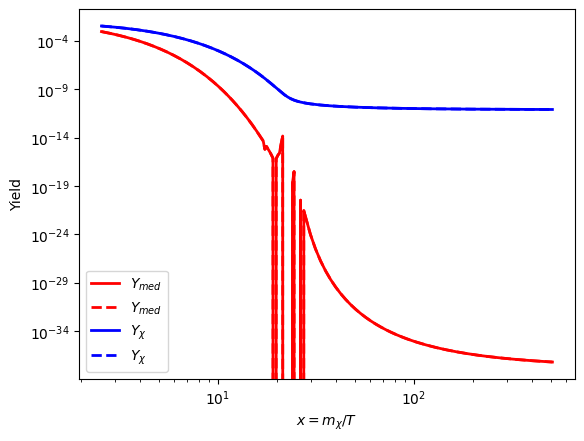

In [ ]:
# fig = plt.figure(figsize=(10,8))
plt.plot(x,y[1,:], 'r', linewidth=2, label = r'$Y_{med}$')
plt.plot(x_sol,y_sol[1,:], 'r', linewidth=2, label = r'$Y_{med}$',linestyle='dashed')

plt.plot(x,y[2,:], 'b', linewidth=2, label = r'$Y_{\chi}$')
plt.plot(x_sol,y_sol[2,:], 'b', linewidth=2, label = r'$Y_{\chi}$',linestyle='dashed')

plt.xlabel(r'$x = m_{\chi}/T$')
plt.ylabel('Yield')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
Ytot = sum(y_sol[1:,-1])
omh2 = 0.12*Ytot/(6.8e-13)
print(f"Omegah2 = {omh2:1.3f}")

Omegah2 = 1.375


In [ ]:
y_sol[:,-1]

array([2.77656634e-01, 6.85739717e-38, 7.79400063e-12])